In [1]:
import os, json, re, time, random
from pathlib import Path
from typing import Dict, Callable, List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
    HashingVectorizer,
)
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Reproducibility
random.seed(42)
np.random.seed(42)

In [2]:
USE_GOOGLE_DRIVE = True

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    BASE = Path("/content/drive/MyDrive/CTC_by_source")
else:
    BASE = Path("/content/CTC_by_source")

RED_PATH = BASE / "CTC_Reddit_10k.json"
STK_PATH = BASE / "CTC_Stackexchange_10k.json"
ARX_PATH = BASE / "CTC_arXiv_10k.json"

WORKDIR = Path("ctc_bench_simplified")
WORKDIR.mkdir(parents=True, exist_ok=True)


TEST_SIZE = 0.20
VAL_SIZE_WITHIN_TRAIN = 0.125
RANDOM_STATE = 42
LIMIT_PER_SOURCE = 4000

Mounted at /content/drive


In [3]:
CLEAN_HTML_RE = re.compile(r"<[^>]+>")
URL_RE        = re.compile(r"http[s]?://\S+|www\.\S+")
CODE_RE       = re.compile(r"`{1,3}.*?`{1,3}", re.DOTALL)
NON_ASCII_RE  = re.compile(r"[^\x00-\x7F]+")
WHITESPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = URL_RE.sub(" ", s)
    s = CODE_RE.sub(" ", s)
    s = CLEAN_HTML_RE.sub(" ", s)
    s = NON_ASCII_RE.sub(" ", s)
    s = WHITESPACE_RE.sub(" ", s).strip()
    return s

def load_json_arr(path: Path, limit: int | None = None, seed: int = RANDOM_STATE):
    """Load a CTC JSON file, optionally subsample for speed."""
    print(f"Loading {path} ...")
    data = json.loads(path.read_text(encoding="utf-8"))

    if limit is not None and len(data) > limit:
        rng = random.Random(seed)
        rng.shuffle(data)
        data = data[:limit]

    X = [clean_text(d["text"]) for d in data]
    y = [int(d["label"]) for d in data]
    return X, y

Xr, yr = load_json_arr(RED_PATH, limit=LIMIT_PER_SOURCE)
Xs, ys = load_json_arr(STK_PATH, limit=LIMIT_PER_SOURCE)
Xa, ya = load_json_arr(ARX_PATH, limit=LIMIT_PER_SOURCE)

print("Reddit:", len(Xr))
print("Stackexchange:", len(Xs))
print("arXiv:", len(Xa))

Loading /content/drive/MyDrive/CTC_by_source/CTC_Reddit_10k.json ...
Loading /content/drive/MyDrive/CTC_by_source/CTC_Stackexchange_10k.json ...
Loading /content/drive/MyDrive/CTC_by_source/CTC_arXiv_10k.json ...
Reddit: 4000
Stackexchange: 4000
arXiv: 4000


In [4]:
import zipfile
import requests
from tqdm import tqdm

CTC_REPO_ZIP = "https://codeload.github.com/epelofske-student/CTC/zip/refs/heads/main"
DICT_REPO_PATH = "English_word_dictionary.txt"

def stream_download(url: str, out_path: Path, desc: str = None) -> Path:
    if out_path.exists() and out_path.stat().st_size > 0:
        return out_path

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(out_path, "wb") as f, tqdm(
            total=total, unit="B", unit_scale=True, desc=desc or out_path.name
        ) as pbar:
            for chunk in r.iter_content(1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    return out_path

def fetch_dictionary(workdir: Path) -> Path:
    data_dir = workdir / "data"
    data_dir.mkdir(parents=True, exist_ok=True)

    repo_zip = data_dir / "CTC-main.zip"
    repo_root = data_dir / "CTC-main"

    if not repo_root.exists():
        stream_download(CTC_REPO_ZIP, repo_zip, "CTC-main.zip")
        with zipfile.ZipFile(repo_zip, "r") as z:
            z.extractall(data_dir)

    dict_path = repo_root / DICT_REPO_PATH
    assert dict_path.exists(), "Dictionary not found in authors' repo"
    return dict_path

DICT_PATH = fetch_dictionary(WORKDIR)
print("Dictionary path:", DICT_PATH)


Dictionary path: ctc_bench_simplified/data/CTC-main/English_word_dictionary.txt


In [5]:
def make_tfidf_dict(dict_path: Path) -> TfidfVectorizer:
    vocab = sorted(
        {w.strip() for w in dict_path.read_text("utf-8").splitlines() if w.strip()}
    )
    return TfidfVectorizer(
        vocabulary=vocab,
        lowercase=True,
        dtype=np.float32,
        token_pattern=r"(?u)\b\w+\b",
        norm="l2",
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True,
    )

def make_tfidf_free() -> TfidfVectorizer:
    return TfidfVectorizer(
        min_df=2,
        ngram_range=(1, 2),
        lowercase=True,
        dtype=np.float32,
    )

def make_tfidf_char() -> TfidfVectorizer:
    return TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        lowercase=True,
        dtype=np.float32,
    )

def make_count() -> CountVectorizer:
    return CountVectorizer(
        min_df=2,
        ngram_range=(1, 2),
        lowercase=True,
        dtype=np.int32,
    )

def make_hashing() -> HashingVectorizer:
    return HashingVectorizer(
        n_features=2**18,
        alternate_sign=False,
        norm="l2",
        lowercase=True,
    )

def make_lsa():
    tfidf = TfidfVectorizer(
        min_df=2, ngram_range=(1, 2), lowercase=True, dtype=np.float32
    )
    svd = TruncatedSVD(n_components=256, random_state=RANDOM_STATE)
    norm = Normalizer(copy=False)
    return make_pipeline(tfidf, svd, norm)


In [6]:
from scipy import sparse

class EnsembleVectorizer:
    """
    Ensemble vectorization method:

    - Combines basic representations:
        * TF-IDF (word)
        * TF-IDF (char 3–5)
        * Hashing / Count-style bag-of-words

    - With a more complex representations:
        * LSA over TF-IDF (low-dimensional semantic features)

    Each component is fit on the same raw text; their feature
    matrices are concatenated horizontally into one large vector.
    This lets us test the hypothesis that mixing simple and
    complex vectorizers outperforms plain TF-IDF on broad,
    noisy sources like Reddit.
    """

    def __init__(self, vec_factories: Dict[str, Callable[[], object]]):
        self.vec_factories = vec_factories
        self.vecs_: Dict[str, object] = {}

    def fit(self, X, y=None):
        self.vecs_ = {name: factory() for name, factory in self.vec_factories.items()}
        for vec in self.vecs_.values():
            vec.fit(X, y)
        return self

    def transform(self, X):
        mats = [vec.transform(X) for vec in self.vecs_.values()]

        # If any part is sparse, convert to sparse and hstack
        if any(sparse.issparse(M) for M in mats):
            mats = [sparse.csr_matrix(M) for M in mats]
            return sparse.hstack(mats).tocsr()
        else:
            return np.hstack(mats)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

class TransformerVectorizer:
    """
    Sklearn-style wrapper around a sentence-transformers model.

    - .fit() is a no-op (no training)
    - .transform() returns dense sentence embeddings

    Default: intfloat/e5-small-v2 (as in the slides).
    You can swap to 'sentence-transformers/all-MiniLM-L6-v2' if desired.
    """
    def __init__(self, model_name: str = "intfloat/e5-small-v2"):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        # No training needed for a frozen encoder
        return self

    def transform(self, X):
        # For e5 we could prefix with "query:" / "passage:",
        # but for document classification we can just encode the raw text.
        emb = self.model.encode(
            X,
            batch_size=32,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True,
        )
        return emb

    def fit_transform(self, X, y=None):
        return self.transform(X)


def make_e5_small_v2() -> TransformerVectorizer:
    """Factory for e5-small-v2 transformer embeddings."""
    return TransformerVectorizer(model_name="intfloat/e5-small-v2")

# (Optional alternative from slides)
# def make_sbert_all_minilm() -> TransformerVectorizer:
#     return TransformerVectorizer(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [8]:
def build_methods(dict_path: Path, methods_subset: List[str] | None = None):
    methods = {
        # Original classical methods
        "tfidf_dict_word":   ("sparse", lambda: make_tfidf_dict(dict_path)),
        "tfidf_free_word":   ("sparse", make_tfidf_free),
        "tfidf_char_3_5":    ("sparse", make_tfidf_char),
        "count_word":        ("sparse", make_count),
        "hashing_word":      ("sparse", make_hashing),
        "lsa_tfidf_svd256":  ("dense",  make_lsa),

        # --- Ensemble vectorizer: simple + complex + transformer ---
        #
        #  - tfidf_free_word      : simple word-level TF-IDF
        #  - tfidf_char_3_5       : char 3–5 TF-IDF (subword / misspellings)
        #  - hashing_word         : high-dimensional bag-of-words
        #  - lsa_tfidf_svd256     : low-dimensional semantic features
        #  - e5_small_v2          : transformer / sentence embedding
        #
        "ensemble_simple_complex": (
            "dense",
            lambda: EnsembleVectorizer(
                {
                    "tfidf_free_word":   make_tfidf_free,
                    "tfidf_char_3_5":    make_tfidf_char,
                    "hashing_word":      make_hashing,
                    "lsa_tfidf_svd256":  make_lsa,
                    "e5_small_v2":       make_e5_small_v2,
                    # If you want both transformers, you could also add:
                    # "sbert_all_minilm":  make_sbert_all_minilm,
                }
            ),
        ),

        # Alias if you’re still using the old name in code
        "ensemble_tfidf_char_lsa": (
            "dense",
            lambda: EnsembleVectorizer(
                {
                    "tfidf_free_word":   make_tfidf_free,
                    "tfidf_char_3_5":    make_tfidf_char,
                    "hashing_word":      make_hashing,
                    "lsa_tfidf_svd256":  make_lsa,
                    "e5_small_v2":       make_e5_small_v2,
                }
            ),
        ),
    }

    if methods_subset is not None:
        methods = {k: v for k, v in methods.items() if k in methods_subset}

    return methods

In [9]:
def split_train_val_test(
    X: List[str], y: List[int],
    test_size: float = TEST_SIZE,
    val_size_within_train: float = VAL_SIZE_WITHIN_TRAIN,
    random_state: int = RANDOM_STATE,
):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_tr,
        y_tr,
        test_size=val_size_within_train,
        random_state=random_state,
        stratify=y_tr,
    )
    return X_tr, y_tr, X_va, y_va, X_te, y_te


In [10]:
def train_eval_method(
    method_name: str,
    X_tr_txt: List[str], y_tr: List[int],
    X_va_txt: List[str], y_va: List[int],
    X_te_txt: List[str], y_te: List[int],
    methods: Dict[str, Tuple[str, Callable[[], object]]],
):
    mtype, factory = methods[method_name]
    timings: Dict[str, float] = {}

    # Build & fit vectorizer
    vec = factory()

    t0 = time.time()
    X_tr = vec.fit_transform(X_tr_txt)
    timings["fit_vectorizer_s"] = time.time() - t0

    t1 = time.time()
    X_va = vec.transform(X_va_txt)
    X_te = vec.transform(X_te_txt)
    timings["transform_s"] = time.time() - t1

    # Choose classifier
    if mtype == "sparse":
        clf = LinearSVC()
    else:  # "dense" incl. LSA + ensemble
        clf = LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")

    t2 = time.time()
    clf.fit(X_tr, y_tr)
    timings["fit_clf_s"] = time.time() - t2

    t3 = time.time()
    yhat = clf.predict(X_te)
    timings["infer_s"] = time.time() - t3

    acc = accuracy_score(y_te, yhat)
    report = classification_report(
        y_te, yhat, output_dict=True, target_names=["non-cybersecurity", "cybersecurity"]
    )

    return acc, report, timings


In [11]:
def run_vectorizer_benchmark_ensemble(
    base_dir: str | Path = BASE,
    limit_per_source: int | None = LIMIT_PER_SOURCE,
    methods: List[str] | None = None,
    results_csv: str = "ctc_ensemble_vs_tfidf.csv",
):
    base_dir = Path(base_dir)

    # 1) Load data
    Xr, yr = load_json_arr(base_dir / "CTC_Reddit_10k.json", limit=limit_per_source)
    Xs, ys = load_json_arr(base_dir / "CTC_Stackexchange_10k.json", limit=limit_per_source)
    Xa, ya = load_json_arr(base_dir / "CTC_arXiv_10k.json", limit=limit_per_source)

    # 2) Dictionary path + method registry
    dict_path = DICT_PATH
    METHODS = build_methods(dict_path, methods_subset=methods)

    rows = []

    def bench_source(name: str, X: List[str], y: List[int]):
        X_tr, y_tr, X_va, y_va, X_te, y_te = split_train_val_test(X, y)
        for m in METHODS.keys():
            print(f"[{name}] {m}")
            acc, report, timing = train_eval_method(
                m, X_tr, y_tr, X_va, y_va, X_te, y_te, METHODS
            )
            rows.append(
                {
                    "source": name,
                    "method": m,
                    "accuracy": acc,
                    **timing,
                }
            )

    bench_source("Reddit", Xr, yr)
    bench_source("Stackexchange", Xs, ys)
    bench_source("arXiv", Xa, ya)

    df_all = pd.DataFrame(rows)
    out_path = WORKDIR / results_csv
    df_all.to_csv(out_path, index=False)
    print("\nSaved results to:", out_path.resolve())

    return df_all


In [12]:
methods_to_compare = [
    "tfidf_dict_word",          # original TF-IDF baseline
    "ensemble_simple_complex",  # ensemble vectorizer
]

df_ensemble = run_vectorizer_benchmark_ensemble(
    base_dir=BASE,
    limit_per_source=LIMIT_PER_SOURCE,  # increase to 3000 when stable
    methods=methods_to_compare,
    results_csv="ctc_ensemble_vs_tfidf.csv",
)

df_ensemble.head()


Loading /content/drive/MyDrive/CTC_by_source/CTC_Reddit_10k.json ...
Loading /content/drive/MyDrive/CTC_by_source/CTC_Stackexchange_10k.json ...
Loading /content/drive/MyDrive/CTC_by_source/CTC_arXiv_10k.json ...
[Reddit] tfidf_dict_word
[Reddit] ensemble_simple_complex


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[Stackexchange] tfidf_dict_word
[Stackexchange] ensemble_simple_complex
[arXiv] tfidf_dict_word
[arXiv] ensemble_simple_complex

Saved results to: /content/ctc_bench_simplified/ctc_ensemble_vs_tfidf.csv


,source,method,accuracy,fit_vectorizer_s,transform_s,fit_clf_s,infer_s
0,Reddit,tfidf_dict_word,0.95750,0.126159,0.039770,0.029263,0.002517
1,Reddit,ensemble_simple_complex,0.98875,223.404159,115.695204,6.242129,0.003921
2,Stackexchange,tfidf_dict_word,0.91500,0.449997,0.193331,0.031735,0.001337
3,Stackexchange,ensemble_simple_complex,0.93125,1298.638868,530.461128,8.594462,0.008752
4,arXiv,tfidf_dict_word,0.98750,16.500691,8.389112,0.198763,0.004412


In [13]:
# Accuracy by method and source
acc_table = df_ensemble.pivot_table(
    index="method", columns="source", values="accuracy"
)
print("Accuracy by method and source:")
display(acc_table)

# Relative improvement of ensemble vs dictionary TF-IDF
baseline = df_ensemble[df_ensemble["method"] == "tfidf_dict_word"] \
    .set_index("source")["accuracy"]
ensemble = df_ensemble[df_ensemble["method"] == "ensemble_tfidf_char_lsa"] \
    .set_index("source")["accuracy"]

rel_improvement = ((ensemble - baseline) / baseline * 100).rename("rel_improvement_%")
print("\nRelative improvement of ensemble over dictionary TF-IDF (%):")
display(rel_improvement)

# Timing comparison
time_cols = ["fit_vectorizer_s", "transform_s", "fit_clf_s", "infer_s"]
time_summary = df_ensemble.groupby("method")[time_cols].mean()
print("\nMean timing (seconds) by method:")
display(time_summary)


Accuracy by method and source:


source,Reddit,Stackexchange,arXiv
method,,,
ensemble_simple_complex,0.98875,0.93125,0.9750
tfidf_dict_word,0.95750,0.91500,0.9875



Relative improvement of ensemble over dictionary TF-IDF (%):


,rel_improvement_%
source,
Reddit,NaN
Stackexchange,NaN
arXiv,NaN



Mean timing (seconds) by method:


,fit_vectorizer_s,transform_s,fit_clf_s,infer_s
method,,,,
ensemble_simple_complex,1563.964950,579.358194,19.008834,0.073267
tfidf_dict_word,5.692282,2.874071,0.086587,0.002755


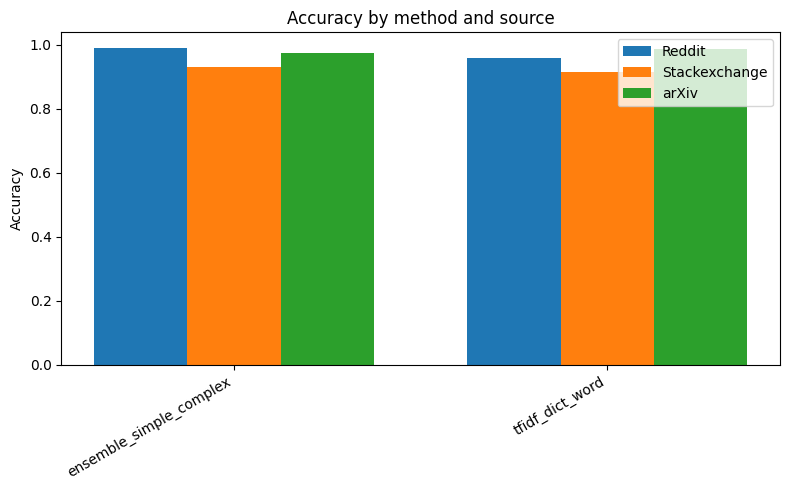

/tmp/ipython-input-166117771.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_acc.index, rotation=30, ha="right")


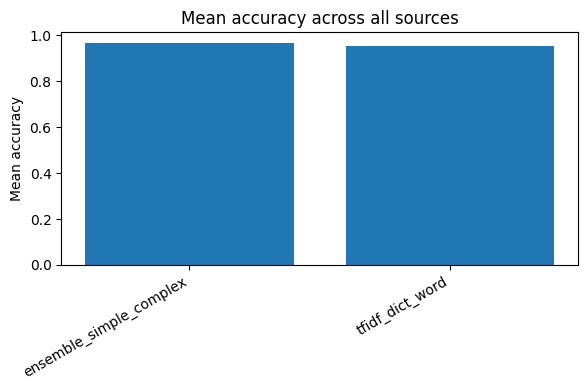

/tmp/ipython-input-166117771.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=30, ha="right")


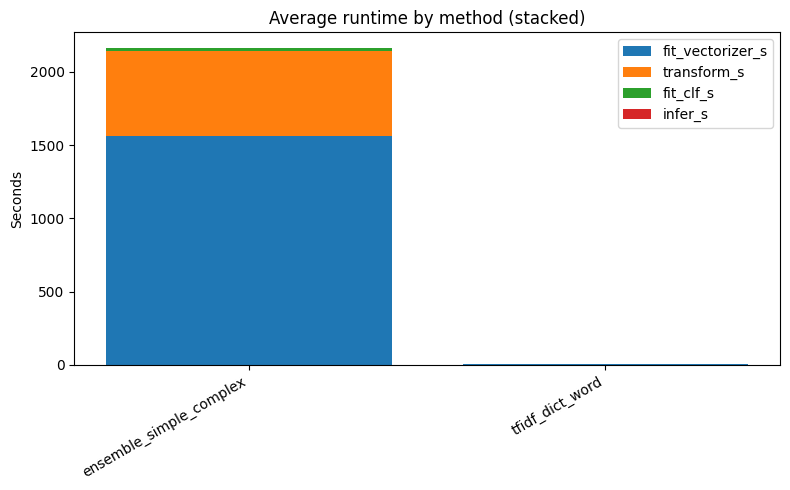

In [14]:
# ============================
# Visualization of results
# ============================
import matplotlib.pyplot as plt
import numpy as np

Accuracy by method and source
acc_pivot = df_ensemble.pivot_table(
    index="method", columns="source", values="accuracy"
).reindex(sorted(df_ensemble["method"].unique()))

fig, ax = plt.subplots(figsize=(8, 5))
sources = acc_pivot.columns.tolist()
methods = acc_pivot.index.tolist()
x = np.arange(len(methods))
width = 0.25

for i, src in enumerate(sources):
    ax.bar(
        x + i * width,
        acc_pivot[src].values,
        width,
        label=src,
    )

ax.set_xticks(x + width)
ax.set_xticklabels(methods, rotation=30, ha="right")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy by method and source")
ax.legend()
plt.tight_layout()
plt.show()


#Mean accuracy per method
mean_acc = df_ensemble.groupby("method")["accuracy"].mean().reindex(methods)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(mean_acc.index, mean_acc.values)
ax.set_xticklabels(mean_acc.index, rotation=30, ha="right")
ax.set_ylabel("Mean accuracy")
ax.set_title("Mean accuracy across all sources")
plt.tight_layout()
plt.show()


#Timing comparison
time_cols = ["fit_vectorizer_s", "transform_s", "fit_clf_s", "infer_s"]
time_means = df_ensemble.groupby("method")[time_cols].mean().reindex(methods)

fig, ax = plt.subplots(figsize=(8, 5))
bottom = np.zeros(len(methods))

for col in time_cols:
    ax.bar(
        methods,
        time_means[col].values,
        bottom=bottom,
        label=col,
    )
    bottom += time_means[col].values

ax.set_xticklabels(methods, rotation=30, ha="right")
ax.set_ylabel("Seconds")
ax.set_title("Average runtime by method (stacked)")
ax.legend()
plt.tight_layout()
plt.show()